<a href="https://colab.research.google.com/github/graceyw/ML-PlanktonIdentifier/blob/master/Plankton_ID.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Load The Data

In [0]:
import gdown
gdown.download('https://drive.google.com/uc?id=1-kEVKnN2wAhdm2Esrk7uWtqFASnMJCI0',  '2014.zip', quiet=False)
!unzip -qq 2014.zip


Downloading...
From: https://drive.google.com/uc?id=1-kEVKnN2wAhdm2Esrk7uWtqFASnMJCI0
To: /content/2014.zip
162MB [00:01, 85.9MB/s]


replace 2014/Chaetoceros/IFCB1_2014_150_192358_00956.png? [y]es, [n]o, [A]ll, [N]one, [r]ename: A
y


# Import The Packages

In [0]:
from torchvision.datasets import ImageFolder
import torch
import time
import torchvision.transforms as transforms
from torch.autograd import Variable
from torch.utils.data.sampler import SubsetRandomSampler
import torch.optim as optim
import torch.nn as nn
import matplotlib.pyplot as plt
import numpy as np

# Preprocess The Data
In this section we take the loaded images and file them into cache that extracts out the targets for the images. The loading of the images and targets into cache instead fo an image folder, resulted in the training speeding up by a factor of 2. Additionally, we take the images and crop them to be square 200x200 images and fill in the background with the average color of the image. We then visualize this to verify its success.

In [0]:
def show_image(img_tensor):
    # need to reorder the tensor dimensions to work properly with imshow
    plt.imshow(img_tensor.transpose(0,2).transpose(0,1))
    plt.axis('off')
    plt.show()
class background_color(object):
  def __init__(self):
    pass
  def __call__(self,sample):
    mask = sample<.001
    sample[mask] = float(np.mean(sample.numpy()[~mask]))
    return sample
class CachedDataset(ImageFolder):
    def __init__(self, root, move_to_GPU=False, transform=transforms.Compose([transforms.CenterCrop((200,200)), transforms.ToTensor(), background_color()]), target_transform=None):
        """ The init method passes most arguments up to the `ImageFolder` class.

            The exception is the `move_to_GPU` input, which if set to true will
            move the returned data to CUDA and if false, will keep it on the CPU
        """
        # make sure to call the super class init method
        super(CachedDataset, self).__init__(root,
                                            transform=transform,
                                            target_transform=target_transform)
        self.total_time_loading = 0
        self.move_to_GPU = move_to_GPU
        # we'll cache the loaded tensors here
        self.tensor_cache = {}

    def __getitem__(self, index):
        """
        Args:
            index (int): Index
        Returns:
            tuple: (image, target) where target is index of the target class.
        """
        t_start = time.time()
        if int(index) in self.tensor_cache:
            self.total_time_loading += time.time() - t_start
            return self.tensor_cache[int(index)]

        inputs, target = super(CachedDataset, self).__getitem__(index)
        
        if self.move_to_GPU:
            self.tensor_cache[int(index)] = inputs.to('cuda'), target
        else:
            self.tensor_cache[int(index)] = inputs, target
        self.total_time_loading += time.time() - t_start
        return self.tensor_cache[int(index)]


Chaetoceros


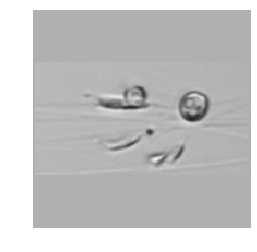

torch.Size([3, 200, 200])

In [0]:


#plankton = ImageFolder(root='./2014', transform=transforms.Compose([transforms.CenterCrop((200,200)), transforms.ToTensor(), background_color()]))

plankton = CachedDataset('./2014')
len(plankton)
im, target = plankton[1000]
print(plankton.classes[target])
show_image(im)
im.shape

# Separating The Data
In this section, we divide out randomly selected subsets of the data into training and testing datasets to be used in our convolutional neural net.

In [0]:
n_train = 10000
batch_size = 32 # could try changing for diff results (between 32->512 is recommended, but one guy did 1 and got good results)
indices = torch.randperm(len(plankton))

train_idx, test_idx = indices[:n_train], indices[n_train:]
train_sampler = SubsetRandomSampler(train_idx)
test_sampler = SubsetRandomSampler(test_idx)

# Get our data into the mini batch size that we defined
train_loader = torch.utils.data.DataLoader(plankton, batch_size=batch_size,
                                        sampler=train_sampler)


test_loader = torch.utils.data.DataLoader(plankton, batch_size=batch_size,
                                        sampler=test_sampler)

# Convolutional Neural Network

In [0]:
class myCNN(nn.Module):
    def __init__(self):
        super(myCNN, self).__init__()
        class_len = 9
        self.activation_func = torch.nn.ReLU()
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2, padding=0)
        self.pool5 = nn.MaxPool2d(kernel_size=5, stride=5, padding=0)
        self.fc1_size = 512      # fully connected layer 1
        self.fc2_size = class_len
        # Convolutional Layers
        self.conv1 = nn.Conv2d(image_dims[0], 32, kernel_size=3,
                  stride=1, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3,
          stride=1, padding=1)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3,
          stride=1, padding=1)
        self.maxpool_output_size = int(128 * (image_dims[1] / 20) * (image_dims[2] / 20))

        # Fully Connected Layers
        self.fc1 = nn.Linear(self.maxpool_output_size, self.fc1_size)
        self.fc2 = nn.Linear(self.fc1_size, self.fc2_size)
        
    def forward(self, x):
        # Convolutional Layers
        x = self.activation_func(self.pool2(self.conv1(x)))
        x = self.activation_func(self.pool2(self.conv2(x)))
        x = self.activation_func(self.pool5(self.conv3(x)))

        # Fully Connected Layers
        x = x.view(-1, self.maxpool_output_size)
        x = self.fc1(x)
        x = self.activation_func(x)
        x = self.fc2(x)
        return x

    def get_loss(self, learning_rate):
      # Loss function, we'll use BCE or Binary CrossEntropy that does not assume one class fer example
      # https://pytorch.org/docs/stable/nn.html
      loss = nn.CrossEntropyLoss()
      # Optimizer, self.parameters() returns all the Pytorch operations that are attributes of the class
      optimizer = optim.Adam(self.parameters(), lr=learning_rate)
      return loss, optimizer

def test_loss(run_idx):
    # do a pass on the test set
    total_test_loss = 0
    total_correct = 0
    idx = 0
    for inputs, labels in test_loader:

        # Wrap tensors in Variables
        inputs, labels = Variable(inputs).to(device), Variable(labels).to(device)

        # Forward pass
        test_outputs = net(inputs)
        test_loss_size = loss(test_outputs, labels)
        total_test_loss += test_loss_size.data.item()
        guess_label = [];

        for image in test_outputs.cpu().detach().numpy():
          guess_label.append(np.argmax(image))
        for i in range(len(labels.cpu().numpy())):
          if guess_label[i] == labels.cpu().numpy()[i]:
            total_correct += 1
        idx += 1
    accuracy = (float(total_correct)/len(test_sampler))
    test_accuracy_hist.append(accuracy)
    test_loss_hist.append(total_test_loss / (idx+1))
    test_hist_x.append(run_idx)
    print("Validation loss = {:.4f}  Validation Accuracy = {:.4f}".format(
        total_test_loss / (idx+1), accuracy))

# Instantiate Neural Net

In [0]:
image_dims = 3,200,200
learning_rate = 3e-3
n_epochs = 8 #number of time it runs through our training data
net = myCNN()
loss, optimizer = net.get_loss(learning_rate)

# Define some parameters to keep track of metrics
print_every = 20
test_every = 200

# Run Convolutional Neural Net

In [0]:
idx = 0
train_hist_x = []
train_loss_hist = []
test_hist_x = []
test_loss_hist = []
test_accuracy_hist = []
device = 'cuda'
net.to(device)

training_start_time = time.time()
for epoch in range(n_epochs):
    running_loss = 0.0
    start_time = time.time()

    for i, data in enumerate(train_loader, 0):
        # Get inputs in right form
        inputs, labels = data
        inputs, labels = Variable(inputs).to(device), Variable(labels).to(device)
        
        # In Pytorch, We need to always remember to set the optimizer gradients to 0 before we recompute the new gradients
        optimizer.zero_grad()

        # Forward pass
        outputs = net(inputs)
        # Compute the loss and find the loss with respect to each parameter of the model
        loss_size = loss(outputs, labels)
        loss_size.backward()
        
        # Change each parameter with respect to the recently computed loss.
        optimizer.step()

        # Update statistics
        running_loss += loss_size.data.item()
        
        # Print every 20th batch of an epoch
        if (i % print_every) == print_every-1:
            print("Epoch {}, Iteration {}\t train_loss: {:.4f} took: {:.4f}s".format(
                epoch + 1, i+1,running_loss / print_every, time.time() - start_time))
            # Reset running loss and time
            train_loss_hist.append(running_loss / print_every)
            train_hist_x.append(idx)
            running_loss = 0.0
            start_time = time.time()
        # Check test set every nth batch
        if (i % test_every) == test_every -1:
            test_loss(idx)
            idx += 1

print("Training finished, took {:.2f}s".format(
    time.time() - training_start_time))

Epoch 1, Iteration 20	 train_loss: 2.3038 took: 4.4836s
Epoch 1, Iteration 40	 train_loss: 1.8228 took: 4.3625s
Epoch 1, Iteration 60	 train_loss: 1.2765 took: 4.3816s
Epoch 1, Iteration 80	 train_loss: 1.0873 took: 4.3555s
Epoch 1, Iteration 100	 train_loss: 0.9773 took: 4.3914s
Epoch 1, Iteration 120	 train_loss: 0.8014 took: 4.3783s
Epoch 1, Iteration 140	 train_loss: 0.8552 took: 4.3932s
Epoch 1, Iteration 160	 train_loss: 0.7703 took: 4.4745s
Epoch 1, Iteration 180	 train_loss: 0.8204 took: 4.4343s
Epoch 1, Iteration 200	 train_loss: 0.7314 took: 4.4205s
Validation loss = 0.6816  Validation Accuracy = 0.7646
Epoch 1, Iteration 220	 train_loss: 0.7114 took: 43.1414s
Epoch 1, Iteration 240	 train_loss: 0.6440 took: 4.5355s
Epoch 1, Iteration 260	 train_loss: 0.6419 took: 4.5424s
Epoch 1, Iteration 280	 train_loss: 0.6745 took: 4.6407s
Epoch 1, Iteration 300	 train_loss: 0.6132 took: 4.5673s
Epoch 2, Iteration 20	 train_loss: 0.6092 took: 1.9570s
Epoch 2, Iteration 40	 train_loss: 0.

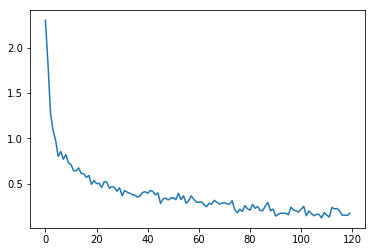

In [0]:
import matplotlib
matplotlib.pyplot.plot(train_loss_hist)

# Testing Accuracy

In [0]:
def test_accuracy():
    # do a pass on the test set
    total_correct = 0

    for inputs, labels in test_loader:

        # Wrap tensors in Variables
        inputs, labels = Variable(inputs).to(device), Variable(labels).to(device)

        # Forward pass
        test_outputs = net(inputs)
        numpy_outputs = test_outputs.cpu().detach().numpy()
        numpy_label = labels.cpu().numpy()
        guess_label = [];
        for image in numpy_outputs:
          guess_label.append(np.argmax(image))
        for i in range(len(numpy_label)):
          if guess_label[i] == numpy_label[i]:
            total_correct += 1
    return(float(total_correct)/len(test_sampler))
test_accuracy()

0.8678168546781685

# Visualize Layer

**In** 
*italicized text*
```
# This is formatted as code
```

bold text this section, we extract the primary layer of the sample image and compare the activation gradient, the original image, and the 

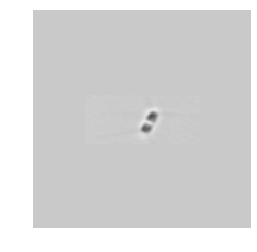

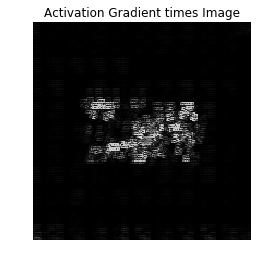

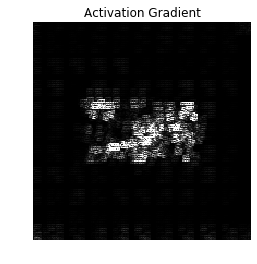

In [0]:
global input_gradients
# Used to grab the gradient
def set_gradient_hook(grad):
    global input_gradients
    input_gradients = grad

im, target = plankton[test_idx[500]]
prep_img = im.to(device)
show_image(prep_img.to('cpu'))
prep_img_unsqueeze = prep_img.unsqueeze(0)
input_img = Variable(prep_img_unsqueeze, requires_grad=True).to(device)
input_img.register_hook(set_gradient_hook)
model_output = net(input_img)
one_hot_output = torch.FloatTensor(1, model_output.size()[-1]).zero_()
one_hot_output[0][target] = 1
model_output.backward(gradient=one_hot_output.to(device))
grad = np.abs(input_gradients.cpu().numpy()).squeeze()

# Normalize Heatmap
grayscale_im = np.sum(grad, axis=0)
im_max = np.percentile(grayscale_im, 99)
im_min = np.min(grayscale_im)
grayscale_im = (np.clip((grayscale_im - im_min) / (im_max - im_min), 0, 1))
masked_img = np.copy(prep_img.to('cpu').transpose(0,2).transpose(0,1).numpy())
plt.imshow(masked_img * grayscale_im[:,:,np.newaxis])
plt.title('Activation Gradient times Image')
plt.axis('off')

plt.show()
plt.imshow(np.ones(masked_img.shape) * grayscale_im[:,:,np.newaxis])
plt.axis('off')
plt.title('Activation Gradient')
plt.show()